# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Arousal Mean Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

song_id  valence_mean_mapped  arousal_mean_mapped
0           2               -0.475               -0.500
1           3               -0.375               -0.425
2           4                0.175                0.125
3           5               -0.150                0.075
4           7                0.200                0.350
...       ...                  ...                  ...
1739     1996               -0.275                0.225
1740     1997                0.075               -0.275
1741     1998                0.350                0.300
1742     1999               -0.100                0.100
1743     2000                0.200                0.250

[1744 rows x 3 columns]

### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_arousal_features_mean = pd.read_csv(get_deam_path('processed/features/normalised_essentia_best_arousal_features.csv'))

# drop Unnamed:0 column
df_essentia_best_arousal_features_mean = df_essentia_best_arousal_features_mean[df_essentia_best_arousal_features_mean.columns[1:]]

df_essentia_best_arousal_features_mean

song_id  lowlevel.average_loudness  lowlevel.barkbands_spread.mean  \
0           2                   0.972741                        0.252048   
1           3                   0.583679                        0.053319   
2           4                   0.990960                        0.252515   
3           5                   0.914417                        0.141958   
4           7                   0.991187                        0.039860   
...       ...                        ...                             ...   
1739     1996                   0.996544                        0.204043   
1740     1997                   0.998184                        0.237238   
1741     1998                   0.911413                        0.367479   
1742     1999                   0.974887                        0.208690   
1743     2000                   0.965636                        0.311659   

      lowlevel.melbands_crest.mean  lowlevel.melbands_flatness_db.mean  \
0                         0.432744                            0.208882   
1                         0.513446                            0.442710   
2                         0.387914                            0.228709   
3                         0.272308                            0.248498   
4                         0.537324                            0.446834   
...                            ...                                 ...   
1739                      0.168527                            0.239557   
1740                      0.280937                            0.379660   
1741                      0.235312                            0.137918   
1742                      0.217848                            0.192222   
1743                      0.289479                            0.195863   

      lowlevel.melbands_kurtosis.mean  lowlevel.melbands_skewness.mean  \
0                            0.023745                         0.224209   
1                            0.082083                         0.348482   
2                            0.018062                         0.213582   
3                            0.016018                         0.181322   
4                            0.107675                         0.349349   
...                               ...                              ...   
1739                         0.013781                         0.186248   
1740                         0.012825                         0.189153   
1741                         0.016787                         0.199106   
1742                         0.022245                         0.224935   
1743                         0.026978                         0.227259   

      lowlevel.melbands_spread.mean  lowlevel.spectral_energy.mean  \
0                          0.173672                       0.054855   
1                          0.026271                       0.211289   
2                          0.184795                       0.084731   
3                          0.122572                       0.041096   
4                          0.017550                       0.197274   
...                             ...                            ...   
1739                       0.153273                       0.077709   
1740                       0.186735                       0.073405   
1741                       0.244384                       0.055710   
1742                       0.136521                       0.054033   
1743                       0.201898                       0.061269   

      lowlevel.spectral_entropy.mean  ...  tonal.chords_histogram_14  \
0                           0.788542  ...                   0.023256   
1                           0.641965  ...                   0.000000   
2                           0.759520  ...                   0.000000   
3                           0.664296  ...                   0.000000   
4                           0.628331  ...                   0.000000   
...                              ...  ... 

In [4]:
df_essentia_best_arousal_features_mean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 305 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    song_id                                  int64  
 1    lowlevel.average_loudness                float64
 2    lowlevel.barkbands_spread.mean           float64
 3    lowlevel.melbands_crest.mean             float64
 4    lowlevel.melbands_flatness_db.mean       float64
 5    lowlevel.melbands_kurtosis.mean          float64
 6    lowlevel.melbands_skewness.mean          float64
 7    lowlevel.melbands_spread.mean            float64
 8    lowlevel.spectral_energy.mean            float64
 9    lowlevel.spectral_entropy.mean           float64
 10   lowlevel.spectral_flux.mean              float64
 11   lowlevel.spectral_kurtosis.mean          float64
 12   lowlevel.spectral_rolloff.mean           float64
 13   lowlevel.spectral_skewness.mean          float64
 14   rhythm

Join both the featureset and annotation set together

In [5]:
df_essentia_best_arousal_features_mean_whole = pd.merge(df_essentia_best_arousal_features_mean, df_annotations, how='inner', on='song_id')
df_essentia_best_arousal_features_mean_whole = df_essentia_best_arousal_features_mean_whole.drop('song_id', axis=1)
df_essentia_best_arousal_features_mean_whole

lowlevel.average_loudness  lowlevel.barkbands_spread.mean  \
0                      0.972741                        0.252048   
1                      0.583679                        0.053319   
2                      0.990960                        0.252515   
3                      0.914417                        0.141958   
4                      0.991187                        0.039860   
...                         ...                             ...   
1739                   0.996544                        0.204043   
1740                   0.998184                        0.237238   
1741                   0.911413                        0.367479   
1742                   0.974887                        0.208690   
1743                   0.965636                        0.311659   

      lowlevel.melbands_crest.mean  lowlevel.melbands_flatness_db.mean  \
0                         0.432744                            0.208882   
1                         0.513446                            0.442710   
2                         0.387914                            0.228709   
3                         0.272308                            0.248498   
4                         0.537324                            0.446834   
...                            ...                                 ...   
1739                      0.168527                            0.239557   
1740                      0.280937                            0.379660   
1741                      0.235312                            0.137918   
1742                      0.217848                            0.192222   
1743                      0.289479                            0.195863   

      lowlevel.melbands_kurtosis.mean  lowlevel.melbands_skewness.mean  \
0                            0.023745                         0.224209   
1                            0.082083                         0.348482   
2                            0.018062                         0.213582   
3                            0.016018                         0.181322   
4                            0.107675                         0.349349   
...                               ...                              ...   
1739                         0.013781                         0.186248   
1740                         0.012825                         0.189153   
1741                         0.016787                         0.199106   
1742                         0.022245                         0.224935   
1743                         0.026978                         0.227259   

      lowlevel.melbands_spread.mean  lowlevel.spectral_energy.mean  \
0                          0.173672                       0.054855   
1                          0.026271                       0.211289   
2                          0.184795                       0.084731   
3                          0.122572                       0.041096   
4                          0.017550                       0.197274   
...                             ...                            ...   
1739                       0.153273                       0.077709   
1740                       0.186735                       0.073405   
1741                       0.244384                       0.055710   
1742                       0.136521                       0.054033   
1743                       0.201898                       0.061269   

      lowlevel.spectral_entropy.mean  lowlevel.spectral_flux.mean  ...  \
0                           0.788542                     0.200886  ...   
1                           0.641965                     0.175158  ...   
2                           0.759520                     0.237563  ...   
3                           0.664296                     0.144694  ...   
4                           0.628331                     0.232717  ...   
...                              ...                          ...  ...   
1739                        0.752389                     0.28383

#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_arousal_features_mean.drop('song_id', axis=1)
features

lowlevel.average_loudness  lowlevel.barkbands_spread.mean  \
0                      0.972741                        0.252048   
1                      0.583679                        0.053319   
2                      0.990960                        0.252515   
3                      0.914417                        0.141958   
4                      0.991187                        0.039860   
...                         ...                             ...   
1739                   0.996544                        0.204043   
1740                   0.998184                        0.237238   
1741                   0.911413                        0.367479   
1742                   0.974887                        0.208690   
1743                   0.965636                        0.311659   

      lowlevel.melbands_crest.mean  lowlevel.melbands_flatness_db.mean  \
0                         0.432744                            0.208882   
1                         0.513446                            0.442710   
2                         0.387914                            0.228709   
3                         0.272308                            0.248498   
4                         0.537324                            0.446834   
...                            ...                                 ...   
1739                      0.168527                            0.239557   
1740                      0.280937                            0.379660   
1741                      0.235312                            0.137918   
1742                      0.217848                            0.192222   
1743                      0.289479                            0.195863   

      lowlevel.melbands_kurtosis.mean  lowlevel.melbands_skewness.mean  \
0                            0.023745                         0.224209   
1                            0.082083                         0.348482   
2                            0.018062                         0.213582   
3                            0.016018                         0.181322   
4                            0.107675                         0.349349   
...                               ...                              ...   
1739                         0.013781                         0.186248   
1740                         0.012825                         0.189153   
1741                         0.016787                         0.199106   
1742                         0.022245                         0.224935   
1743                         0.026978                         0.227259   

      lowlevel.melbands_spread.mean  lowlevel.spectral_energy.mean  \
0                          0.173672                       0.054855   
1                          0.026271                       0.211289   
2                          0.184795                       0.084731   
3                          0.122572                       0.041096   
4                          0.017550                       0.197274   
...                             ...                            ...   
1739                       0.153273                       0.077709   
1740                       0.186735                       0.073405   
1741                       0.244384                       0.055710   
1742                       0.136521                       0.054033   
1743                       0.201898                       0.061269   

      lowlevel.spectral_entropy.mean  lowlevel.spectral_flux.mean  ...  \
0                           0.788542                     0.200886  ...   
1                           0.641965                     0.175158  ...   
2                           0.759520                     0.237563  ...   
3                           0.664296                     0.144694  ...   
4                           0.628331                     0.232717  ...   
...                              ...                          ...  ...   
1739                        0.752389                     0.28383

In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

valence_mean_mapped  arousal_mean_mapped
0                  -0.475               -0.500
1                  -0.375               -0.425
2                   0.175                0.125
3                  -0.150                0.075
4                   0.200                0.350
...                   ...                  ...
1739               -0.275                0.225
1740                0.075               -0.275
1741                0.350                0.300
1742               -0.100                0.100
1743                0.200                0.250

[1744 rows x 2 columns]

Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [36]:
num_epochs = 162

Set a random seed to ensure consistent initial weights of the neural network

In [37]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [38]:
sys.path.insert(1, '../../models')
from feedforward_nn import NeuralNetwork

#### Training

Prepare input_train_data and target_train_labels

In [39]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 304])


Training loop

In [40]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [41]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5725887545039975
Epoch 2, Loss: 0.5715604219143373
Epoch 3, Loss: 0.570593281435731
Epoch 4, Loss: 0.5696679222103515
Epoch 5, Loss: 0.568831493491882
Epoch 6, Loss: 0.5681043229573666
Epoch 7, Loss: 0.5673889580031046
Epoch 8, Loss: 0.5667243590391555
Epoch 9, Loss: 0.566131551492811
Epoch 10, Loss: 0.5655937154559013
Epoch 11, Loss: 0.5650555520893689
Epoch 12, Loss: 0.5645260351274336
Epoch 13, Loss: 0.5640070383380114
Epoch 14, Loss: 0.5634971363668444
Epoch 15, Loss: 0.5629945276580516
Epoch 16, Loss: 0.5624994966716633
Epoch 17, Loss: 0.5620125406824328
Epoch 18, Loss: 0.5615383511096979
Epoch 19, Loss: 0.5610774383680948
Epoch 20, Loss: 0.5606276556949379
Epoch 21, Loss: 0.5601885776954166
Epoch 22, Loss: 0.5597583927344854
Epoch 23, Loss: 0.5593337379453345
Epoch 24, Loss: 0.5589112666509868
Epoch 25, Loss: 0.5584892228503139
Epoch 26, Loss: 0.558062080305388
Epoch 27, Loss: 0.5576226389496549
Epoch 28, Loss: 0.5571697196755087
Epoch 29, Loss: 0.556716351628390

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [42]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 304])


Generating scores

In [43]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [44]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.2231558452924459
Valence RMSE: 0.21026563358984324
Arousal RMSE: 0.23534108418938227
Test R^2 score: tensor([0.4642, 0.4516], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-3.2377, -3.3374], dtype=torch.float64)
Test R^2 score (overall): 0.4578952910159231


In [45]:
torch.save(model.state_dict(), '../../models/deam_feedforward_nn_essentia_best_arousal_mean_normalised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [23]:
test_pred

tensor([[ 1.3165e-01,  1.4205e-01],
        [-2.8662e-01, -3.3633e-01],
        [ 2.5832e-01,  2.6918e-01],
        [-3.4985e-02, -6.3557e-02],
        [-1.2285e-01, -1.5940e-01],
        [-2.5660e-01, -3.0071e-01],
        [-4.1834e-01, -5.2390e-01],
        [ 2.1863e-01,  2.2334e-01],
        [-3.3644e-01, -4.0312e-01],
        [ 2.4220e-01,  2.5289e-01],
        [ 2.0420e-01,  2.0931e-01],
        [-1.4234e-01, -1.7566e-01],
        [-3.4332e-01, -4.1209e-01],
        [ 2.9989e-01,  3.0624e-01],
        [ 2.1451e-01,  2.2234e-01],
        [-3.6455e-02, -6.4617e-02],
        [-3.8297e-01, -4.7310e-01],
        [-8.3400e-02, -1.2080e-01],
        [ 2.2386e-01,  2.3861e-01],
        [-3.2878e-01, -3.9135e-01],
        [-2.3477e-01, -2.7019e-01],
        [-3.6182e-01, -4.4348e-01],
        [-4.3314e-01, -5.4425e-01],
        [ 1.7786e-01,  1.8801e-01],
        [ 2.3118e-01,  2.4677e-01],
        [ 2.1443e-01,  2.2188e-01],
        [ 3.0615e-01,  3.0398e-01],
        [ 1.0748e-01,  1.103

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.4445, 0.4369], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 501)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5725887545039975
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3253846066365878
Valence RMSE: 0.2879142833660034
Arousal RMSE: 0.35896469172598944
Test R^2 score: tensor([-0.0046, -0.2759], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-6.9455, -9.0911], dtype=torch.float64)
Test R^2 score (overall): -0.14024358493282252
Num of epochs: 2
Epoch 1, Loss: 0.5725887545039975
Epoch 2, Loss: 0.5715604219143373
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3242479286669338
Valence RMSE: 0.2881164763932062
Arousal RMSE: 0.3567384679570694
Test R^2 score: tensor([-0.0060, -0.2601], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-6.9566, -8.9663], dtype=torch.float64)
Test R^2 score (overall): -0.13306108143295226
Num of epochs: 3
Epoch 1, Loss: 0.5725887545039975
Epoch 2, Loss: 0.5715604219143373
Epoch 3, Loss: 0.570593281435731
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3

### Plot the graph to visualise the relationship between the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

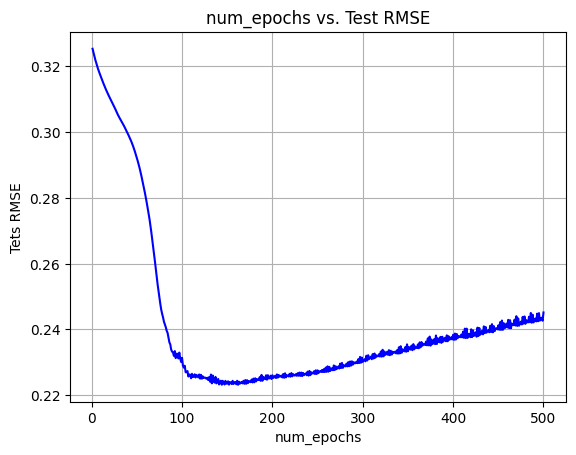

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.2231558452924459
Corresponding R^2 SCore: 0.4578952910159231
Corresponding num_epochs: 162


#### Test R^2 Score vs. num_epochs

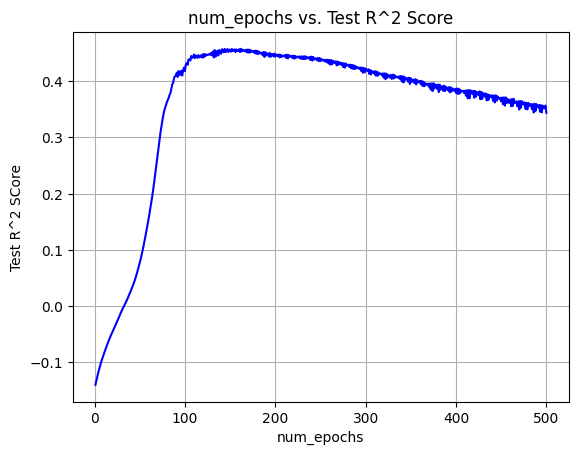

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.4578952910159231
Corresponding RMSE: 0.2231558452924459
Corresponding num_epochs: 162


#### Test Adjusted R^2 SCore (Valence) vs. num_epochs

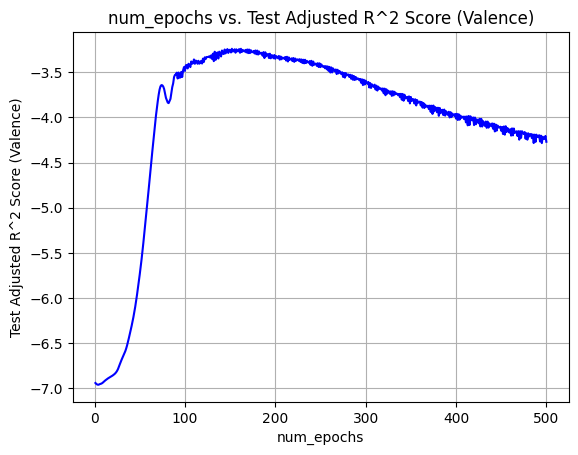

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: -3.237696041454087
Corresponding RMSE: 0.2231558452924459
Corresponding num_epochs: 162


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

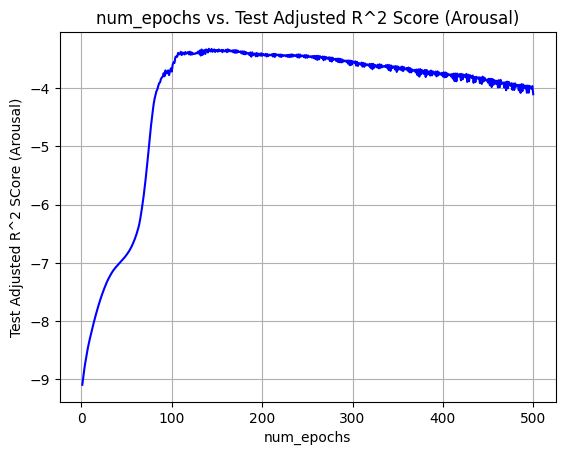

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: -3.3288810045311887
Corresponding RMSE: 0.22325465645369305
Corresponding num_epochs: 141
